In [ ]:
import gymnasium as gym
import numpy as np

from stable_baselines3 import DQN
from TestEnv import HydroElectric_Test
from stable_baselines3.common.noise import NormalActionNoise

from src.models.Qlearning import QAgent
from src.env.TestEnv import HydroElectric_Test
import matplotlib.pyplot as plt
import random

from DQQN import DQNWrapper

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [2]:
seed = 5
np.random.seed(seed)
random.seed(seed)
num_actions = 5

In [3]:
hydro_env = HydroElectric_Test("train.xlsx")
env = DQNWrapper(hydro_env, reward_shape = True, num_actions=num_actions )
env.reset(seed=seed)


(array([0.5     , 0.009724, 0.      , 0.      , 0.      ], dtype=float32), {})

In [5]:
# model = DQN("MlpPolicy", env, verbose=1)
# model = DQN(
#     "MlpPolicy", 
#     env, 
#     verbose=1,
#     learning_rate=1e-4,
#     buffer_size=50000,
#     learning_starts=5000,
#     batch_size=128,
#     train_freq=4,
#     gradient_steps=1,             
#     target_update_interval=1000,
#     # tau=0.005,
#     gamma=0.99,
#     exploration_fraction=0.3,
#     exploration_initial_eps=1.0,
#     exploration_final_eps=0.05,
# )
# model.learn(total_timesteps=200_000, log_interval=10)
#     action, _states = model.predict(obs, deterministic=True)
#     obs, reward, terminated, truncated, info = env.step(action)
#     if terminated or truncated:
#         obs, info = env.reset()

# model = DQN("MlpPolicy", env, verbose=1)
policy_kwargs = dict(net_arch=[256, 256, 128])
model = DQN(
    "MlpPolicy", 
    env, 
    policy_kwargs=policy_kwargs,
    learning_rate=5e-4,
    buffer_size=100_000,
    learning_starts=10_000,
    batch_size=256,
    train_freq=4,
    gradient_steps=2,             
    target_update_interval=3000,
    tau=0.005,
    gamma=0.995,
    exploration_fraction=0.4,
    exploration_final_eps=0.02,
    verbose=1,
)
model.learn(total_timesteps=500_000, log_interval=10)

model.save("dqn_model")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 2.63e+04  |
|    ep_rew_mean      | -4.05e+05 |
|    exploration_rate | 0.02      |
| time/               |           |
|    episodes         | 10        |
|    fps              | 350       |
|    time_elapsed     | 750       |
|    total_timesteps  | 263030    |
| train/              |           |
|    learning_rate    | 0.0005    |
|    loss             | 0.118     |
|    n_updates        | 126514    |
-----------------------------------


In [6]:
hydro_env_test = HydroElectric_Test("validate.xlsx")
env_test = DQNWrapper(hydro_env, reward_shape = False, num_actions=num_actions)

model = DQN.load("dqn_model")

obs, _ = env.reset(seed=seed)
env.reward_shape = False 
obs = np.array(obs, dtype=np.float32)
done = False
water_levels = []
rewards = []
actions = []

while not done:
    action, _ = model.predict(obs, deterministic=True)
    action = int(action)
    
    obs, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    
    water_levels.append(env.env.volume)  # dam level
    rewards.append(reward)
    actions.append(action)
    # obs = np.array(obs, dtype=np.float32)

print("Totale reward:", sum(rewards))
print("Gemiddelde reward:", np.mean(rewards))

Totale reward: 7034.675817861149
Gemiddelde reward: 0.26744766064179576


In [7]:
print(len(set(water_levels)))
print(set(actions))
print(len(set(rewards)))

18
{0, 1, 2, 3, 4}
268


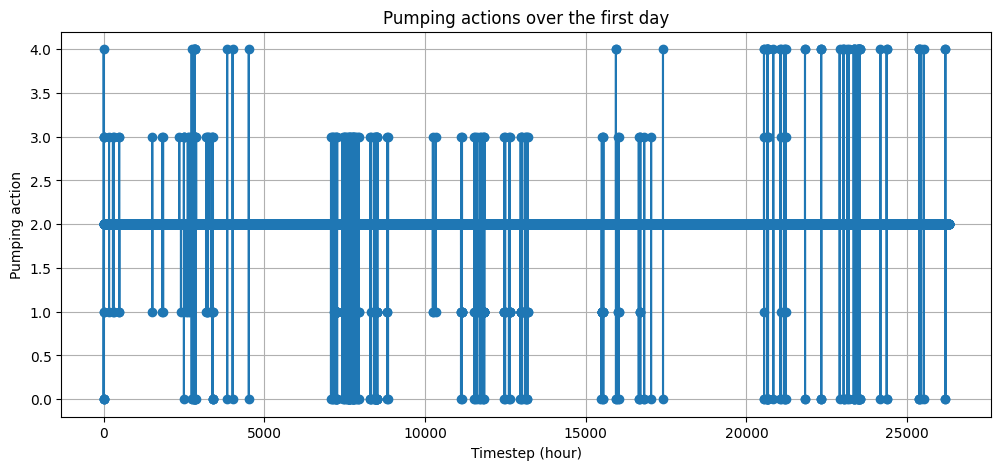

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(actions[:], marker='o')  # eerste 24 uur
plt.title("Pumping actions over the first day")
plt.xlabel("Timestep (hour)")
plt.ylabel("Pumping action")
plt.grid(True)
plt.show()

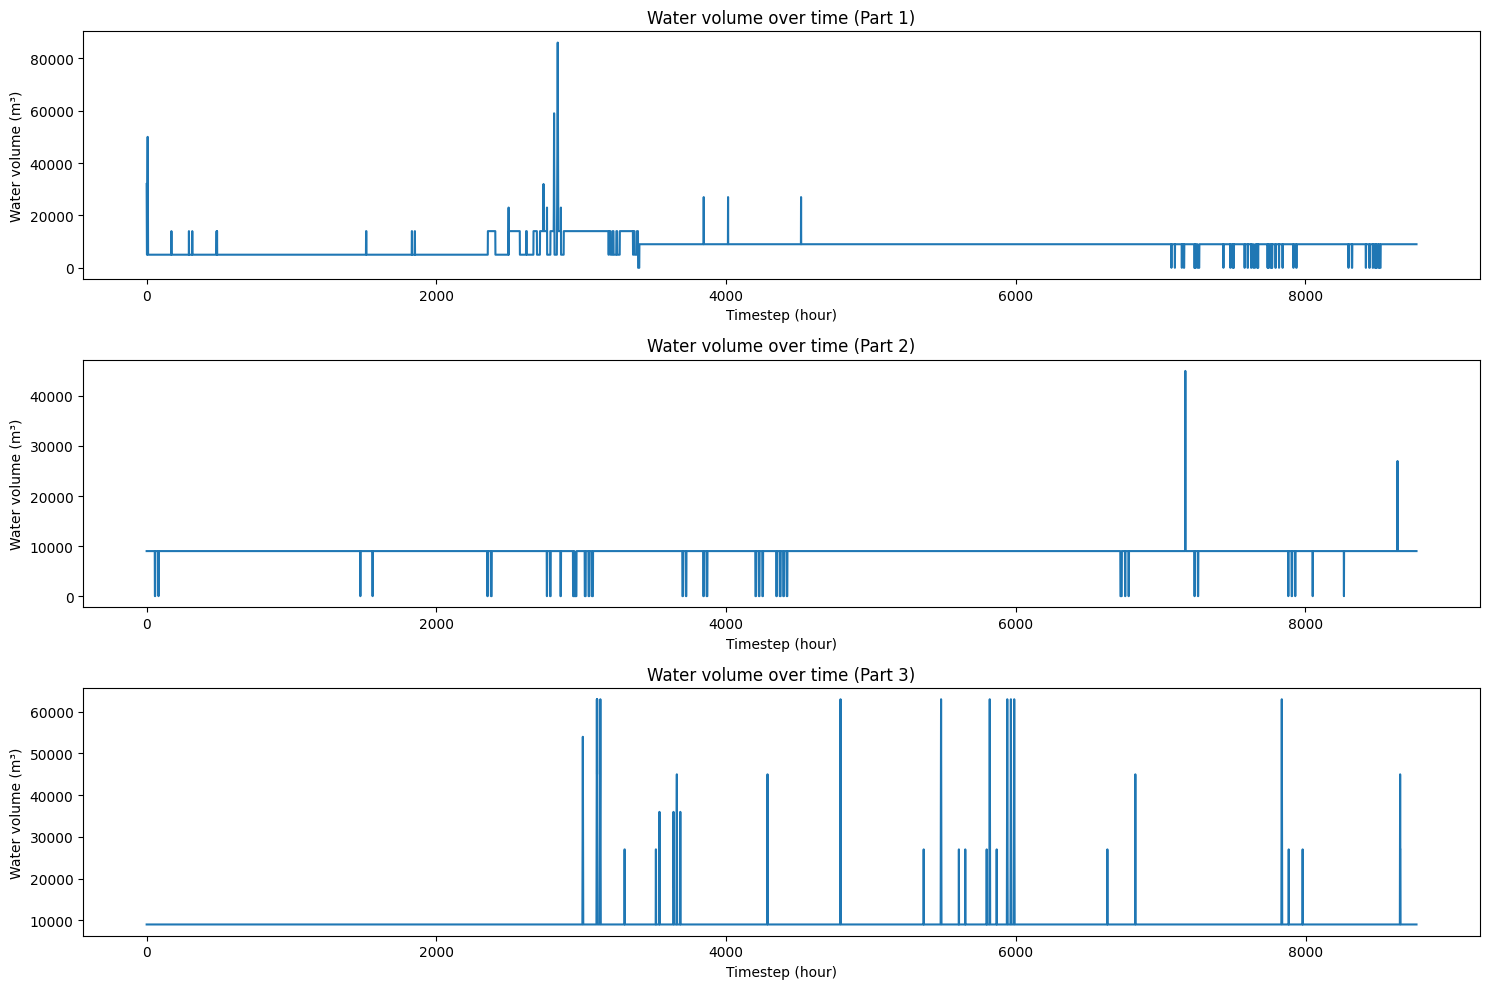

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Stel: water_levels bevat alle uren over 3 jaar
# en env.max_volume is de maximale waterhoeveelheid

# Aantal plots
n_plots = 3

# Verdeel de data in n_plots stukken
chunks = np.array_split(water_levels, n_plots)

plt.figure(figsize=(15,10))

for i, chunk in enumerate(chunks, 1):
    plt.subplot(n_plots, 1, i)
    plt.plot(chunk)
    # plt.axhline(env.max_volume, color='r', linestyle='--', alpha=0.7)
    plt.title(f"Water volume over time (Part {i})")
    plt.xlabel("Timestep (hour)")
    plt.ylabel("Water volume (m³)")

plt.tight_layout()
plt.show()


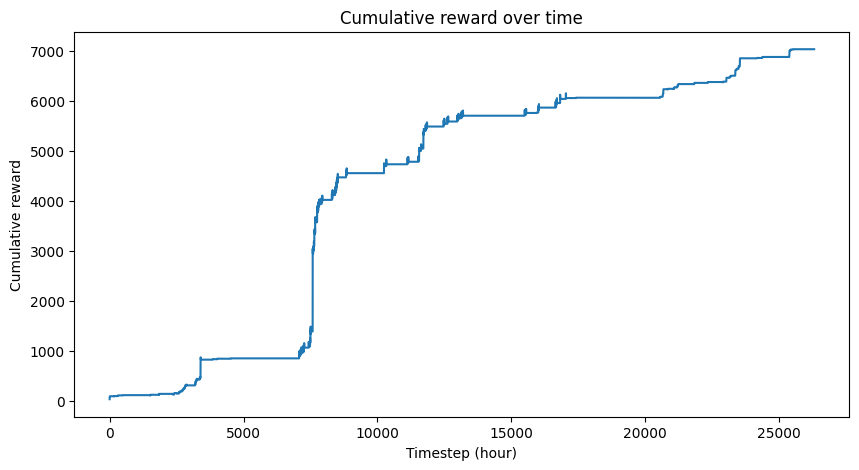

In [10]:
# Plot cumulatieve reward
%matplotlib inline
cumulative_rewards = np.cumsum(rewards)
plt.figure(figsize=(10,5))
plt.plot(cumulative_rewards)
plt.title("Cumulative reward over time")
plt.xlabel("Timestep (hour)")
plt.ylabel("Cumulative reward")
plt.show()

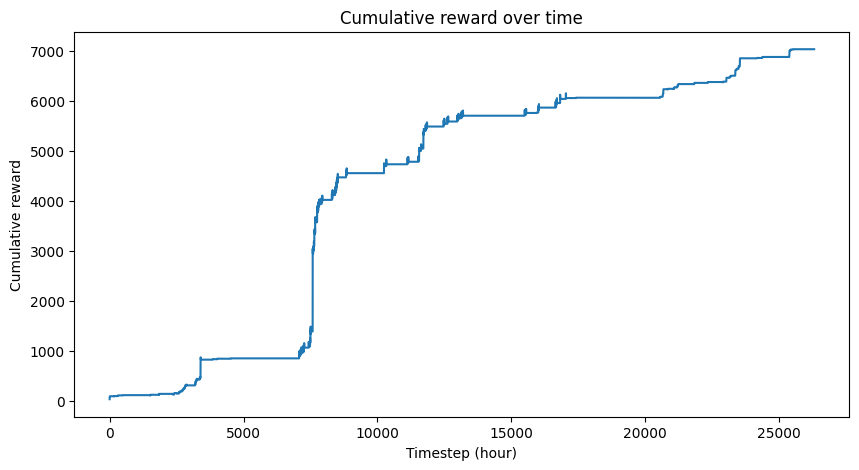

In [11]:
# Plot cumulatieve reward
%matplotlib inline
cumulative_rewards = np.cumsum(rewards)
plt.figure(figsize=(10,5))
plt.plot(cumulative_rewards)
plt.title("Cumulative reward over time")
plt.xlabel("Timestep (hour)")
plt.ylabel("Cumulative reward")
plt.show()